In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from tensorflow.keras import utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dense, Dropout, Embedding, BatchNormalization, 
                                     Flatten, Conv1D, SpatialDropout1D, 
                                     GlobalAveragePooling1D, GlobalMaxPooling1D,
                                     LSTM, Input, SimpleRNN, Bidirectional)
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from google.colab import files

from sklearn.preprocessing import StandardScaler
from sklearn import manifold
from sklearn.manifold import TSNE 
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn.cluster import AgglomerativeClustering

from scipy import ndimage

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def read_text(file_name):
    t = open(file_name, 'r')
    text = t.read()
    text = text.replace('\n', '')
    return text

In [4]:
# Создаем классы
class_name = ['Братья Стругацкие', 'К. Саймак', 'М. Фрай', 'М. Булгаков', 'О. Генри', 'Р. Брэдберри']
n_classes = len(class_name)
n_classes

6

In [5]:
train_text = []
test_text = []

for i in class_name:
    for j in os.listdir('/content/drive/MyDrive/UAI/Data_CSV/texts/'):
        if i in j:
            if 'Обучающая' in j:
                train_text.append(read_text('/content/drive/MyDrive/UAI/Data_CSV/texts/' + j))
                print(j, 'Добавлен в обучающую выборку')
            if 'Тестовая' in j:
                test_text.append(read_text('/content/drive/MyDrive/UAI/Data_CSV/texts/' + j))
                print(j, 'Добавлен в Тестовую выборку')
    print()

(Братья Стругацкие) Обучающая.txt Добавлен в обучающую выборку
(Братья Стругацкие) Тестовая.txt Добавлен в Тестовую выборку

(К. Саймак) Обучающая.txt Добавлен в обучающую выборку
(К. Саймак) Тестовая.txt Добавлен в Тестовую выборку

(М. Фрай) Обучающая.txt Добавлен в обучающую выборку
(М. Фрай) Тестовая.txt Добавлен в Тестовую выборку

(М. Булгаков) Обучающая.txt Добавлен в обучающую выборку
(М. Булгаков) Тестовая.txt Добавлен в Тестовую выборку

(О. Генри) Тестовая.txt Добавлен в Тестовую выборку
(О. Генри) Обучающая.txt Добавлен в обучающую выборку

(Р. Брэдберри) Обучающая.txt Добавлен в обучающую выборку
(Р. Брэдберри) Тестовая.txt Добавлен в Тестовую выборку



In [10]:
# Преобразовываем текстовые данные в цифровые
max_word_count = 50000
tokenizer = Tokenizer(num_words=max_word_count, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer.fit_on_texts(train_text)
items = list(tokenizer.word_index.items())

In [11]:
train_word_indexes = tokenizer.texts_to_sequences(train_text)
test_word_indexes = tokenizer.texts_to_sequences(test_text)

In [12]:
# Ищем редко встречающиеся слова
rare_words = 2
low_rare_words = [w for w, v in tokenizer.word_counts.items() if v < rare_words]

print(low_rare_words)

['преисподней1ну', 'выжжена', 'сетями', 'полевая', 'снятая', 'крестец', 'окоркам', 'выволоклись', 'огородные', 'обомлели', 'голенищу', 'навоевали', 'воинская', 'бригадные', 'интенданты', 'ходячее', 'удобрение', 'смазка', 'штыка', 'гуляючи', 'маскировочный', 'шесте', 'вьюках', 'раненом', 'драном', 'обгоревшем', 'маскировочном', 'опаленными', 'егерей', 'дигга', 'опалило', 'смола', 'отступаю', 'бронеходах', 'дикобразами', 'бредил', 'затянулись', 'вцепляясь', 'запрокинутого', 'рокаде', 'бомбовым', 'расчищали', 'лезущих', 'заскорузлую', 'беспросветное', 'околицу', 'съехавший', 'завалившийся', 'бортовым', 'дохлый', 'отрыли', 'околицей', 'посеяно', 'окопов', 'хоботы', 'увязнув', 'селу', 'лафете', 'щепочкой', 'рассерженные', 'изрыгал', 'выронивши', 'пикнули', 'мордам', 'бакенбардах', 'прожилках', 'захватанное', 'гепардом', 'приуменьшился', 'седенький', 'росточка', 'подкреплений', 'пулеметах', 'ракетометах', 'потертостями', 'грыжей', 'полированная', 'тросточка', 'бронепехоты', 'крысоеда', 'гого

In [13]:
# Удаляем редко встречающиеся слова
for w in low_rare_words:
    del tokenizer.word_index[w]
    del tokenizer.word_docs[w]
    del tokenizer.word_counts[w]

In [14]:
# Создаем функции для формирования выборок (ширина, шаг)
def get_set_from_indexes(word_indexes, w_len, step):
    X_sample = []
    words_len = len(word_indexes)
    index = 0

    while(index + w_len <= words_len):
        X_sample.append(word_indexes[index:index + w_len])
        index += step

    return X_sample

In [15]:
# Из двух листов индексов двух классов формируем обучающую и проверочную выборки
def create_sets_multi_classes(word_indexes, w_len, step):
    n_classes = len(word_indexes)
    classes_X_samples = []
    for wI in word_indexes:
        classes_X_samples.append(get_set_from_indexes(wI, w_len, step))

# Формируем общий X_samples, y_samples
    X_samples = []
    y_samples = []

    for n in range(n_classes):
        x_t = classes_X_samples[n]
        for i in range(len(x_t)):
            X_samples.append(x_t[i])
            y_samples.append(utils.to_categorical(n, n_classes))

    X_samples = np.array(X_samples)
    y_samples = np.array(y_samples)

    return (X_samples, y_samples)

In [16]:
# Задаем параметры
w_len = 1000
step = 100

In [17]:
# Создаем обучающую и тестовую выборки
X_train, y_train = create_sets_multi_classes(train_word_indexes, w_len, step)
X_test, y_test = create_sets_multi_classes(test_word_indexes, w_len, step)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(17634, 1000)
(17634, 6)
(6683, 1000)
(6683, 6)


In [18]:
input_emb = Input(shape=(w_len))
embed = Embedding(input_dim=max_word_count, output_dim=64)(input_emb)
x = SpatialDropout1D(0.6)(embed)
x = BatchNormalization()(x)
x = LSTM(64, return_sequences=True)(x)
x = Dropout(0.4)(x)
x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
#x = SpatialDropout1D(0.6)(x)
x = Dropout(0.6)(x)
x = BatchNormalization()(x)
x = Flatten()(x)
out = Dense(6, activation='softmax')(x)

embedding = Model(input_emb, embed)

model = Model(input_emb, out)


In [19]:
model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 1000, 64)          3200000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 1000, 64)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1000, 64)          256       
_________________________________________________________________
lstm (LSTM)                  (None, 1000, 64)          33024     
_________________________________________________________________
dropout (Dropout)            (None, 1000, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1000, 64)          256 

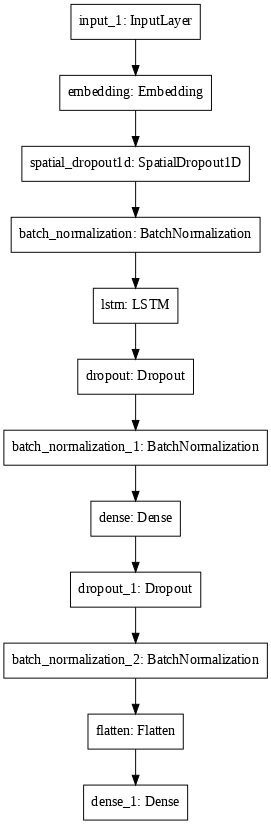

In [20]:
model.summary()
print('_ _ _ _ _ MODEL _ _ _ _ _ ')
plot_model(model, dpi=70)

In [21]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100
552/552 [==============================] - 39s 64ms/step - loss: 1.9665 - accuracy: 0.3383 - val_loss: 5.2153 - val_accuracy: 0.1610
Epoch 2/100
552/552 [==============================] - 35s 63ms/step - loss: 0.9593 - accuracy: 0.6638 - val_loss: 5.0483 - val_accuracy: 0.2770
Epoch 3/100
552/552 [==============================] - 34s 62ms/step - loss: 0.3253 - accuracy: 0.8864 - val_loss: 4.6072 - val_accuracy: 0.3635
Epoch 4/100
552/552 [==============================] - 35s 63ms/step - loss: 0.1086 - accuracy: 0.9639 - val_loss: 4.7314 - val_accuracy: 0.4399
Epoch 5/100
552/552 [==============================] - 34s 62ms/step - loss: 0.0536 - accuracy: 0.9815 - val_loss: 3.0511 - val_accuracy: 0.5677
Epoch 6/100
552/552 [==============================] - 35s 63ms/step - loss: 0.0355 - accuracy: 0.9885 - val_loss: 3.7224 - val_accuracy: 0.5625
Epoch 7/100
552/552 [==============================] - 35s 63ms/step - loss: 0.0278 - accuracy: 0.9905 - val_loss: 2.4391 - val_ac

In [17]:
# точность модели Embedding+LSTM
normal_accuracy = model.evaluate(X_test, y_test)[1]
normal_accuracy

209/209 [==============================] - 4s 17ms/step - loss: 4.2402 - accuracy: 0.7404


0.7403860688209534

In [18]:
# максимальная точность  и ошибка на обучающей и проверочной выборе
print(f'Максимальная точность обучающей выборки: {max(history.history["accuracy"])} \
\nМинимальная ошибка на обучающей выборе: {min(history.history["loss"])} \
\nМаксимальная точность проверочной выборки: {max(history.history["val_accuracy"])} \
\nМинимальная ошибка на проверочной выборе: {min(history.history["val_loss"])}')

Максимальная точность обучающей выборки: 0.9954066276550293 
Минимальная ошибка на обучающей выборе: 0.014403434470295906 
Максимальная точность проверочной выборки: 0.8066736459732056 
Минимальная ошибка на проверочной выборе: 1.5482960939407349


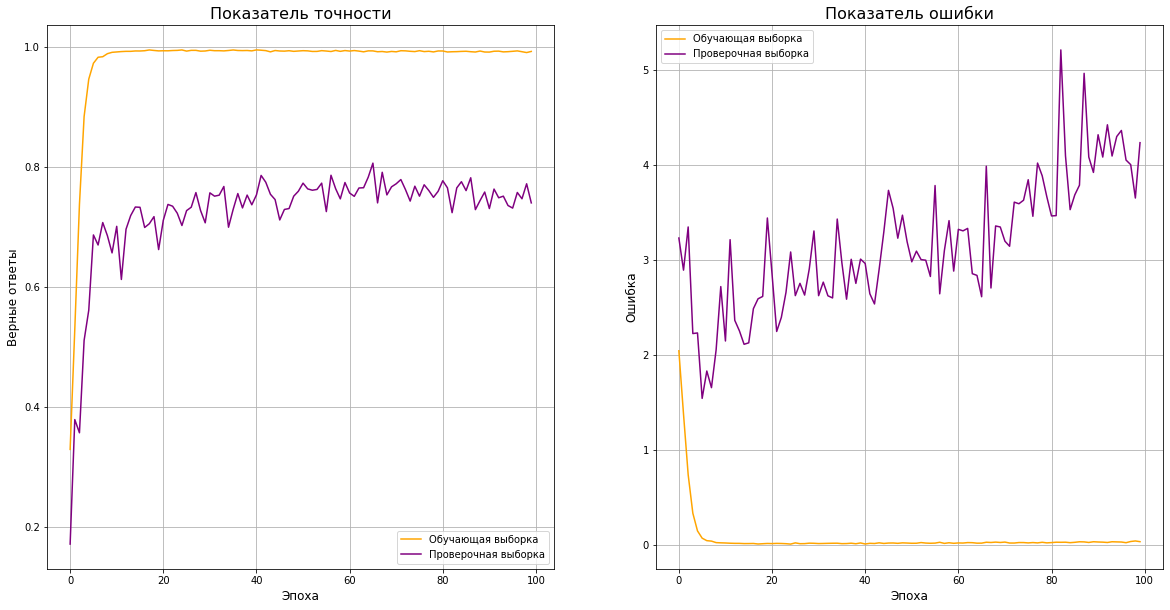

In [19]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], color='orange', label='Обучающая выборка')
plt.plot(history.history['val_accuracy'], color='purple', label='Проверочная выборка')
plt.title('Показатель точности', fontsize=16)
plt.xlabel('Эпоха', fontsize=12)
plt.ylabel('Верные ответы', fontsize=12)
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], color='orange', label='Обучающая выборка')
plt.plot(history.history['val_loss'], color='purple', label='Проверочная выборка')
plt.title('Показатель ошибки', fontsize=16)
plt.xlabel('Эпоха', fontsize=12)
plt.ylabel('Ошибка', fontsize=12)
plt.legend()
plt.grid()

plt.show()

При подаче всего набора вылетает Colab. ОЗУ.

In [99]:
#X embedding для кластеризации
X = embedding.predict(X_train[:10000], batch_size=100)

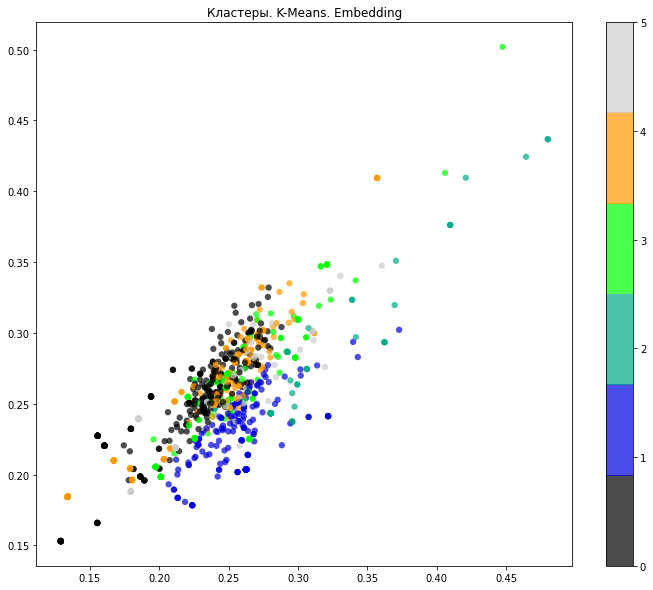

In [102]:
# Вывод кластеров текстов писателей K_Means
n_clusters = 6
kmeans = KMeans(n_clusters, n_init=100, random_state=17)
e_kmeans = kmeans.fit_transform(X[0])
labels = kmeans.labels_
 

plt.figure(figsize=(12, 10))
plt.scatter(e_kmeans[:, 0], e_kmeans[:, 1], c=labels, edgecolor='none', alpha=0.7, s=40, cmap=plt.cm.get_cmap('nipy_spectral', 6))  #Accent
plt.colorbar()
#centers = kmeans.cluster_centers_
#plt.scatter(centers[:, 0], centers[:, 1], c = 'red', s = 50, alpha = 1)
plt.title('Кластеры. K-Means. Embedding')
plt.show()

In [24]:
# Размер каждого кластера
cluster_size = [sum(labels == i) for i in range(0, n_clusters)]
for i, s in enumerate(cluster_size):
    print(f'Кластер: {i} Размер= {s}')

Кластер: 0 Размер= 281
Кластер: 1 Размер= 159
Кластер: 2 Размер= 47
Кластер: 3 Размер= 158
Кластер: 4 Размер= 249
Кластер: 5 Размер= 106


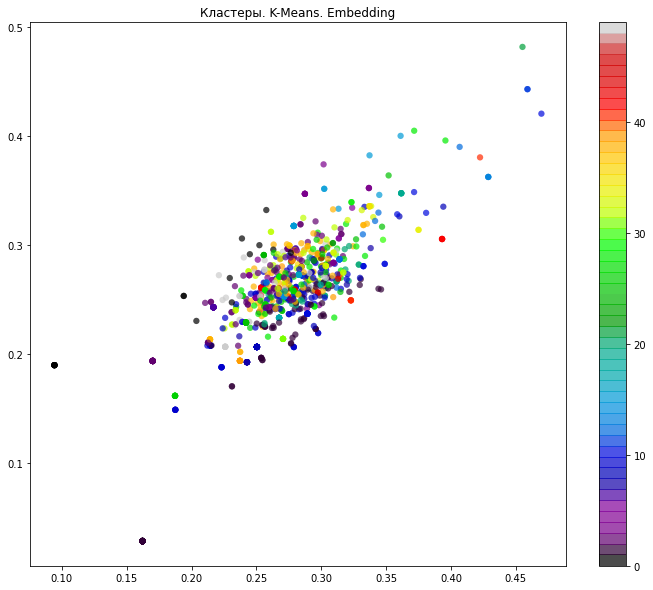

In [25]:
# Вывод 50 кластеров текстов писателей K_Means
n_clusters = 50
kmeans = KMeans(n_clusters, n_init=100, random_state=17)
e_kmeans = kmeans.fit_transform(X[0])
labels = kmeans.labels_
 

plt.figure(figsize=(12, 10))
plt.scatter(e_kmeans[:, 0], e_kmeans[:, 1], c=labels, edgecolor='none', alpha=0.7, s=40, cmap=plt.cm.get_cmap('nipy_spectral', 50))  #Accent
plt.colorbar()
#centers = kmeans.cluster_centers_
#plt.scatter(centers[:, 0], centers[:, 1], c = 'red', s = 50, alpha = 1)
plt.title('Кластеры. K-Means. Embedding')
plt.show()

In [26]:
# Размер каждого кластера

cluster_size = [sum(labels == i) for i in range(0, n_clusters)]
for i, s in enumerate(cluster_size):
    print(f'Кластер: {i} Размер= {s}')

Кластер: 0 Размер= 19
Кластер: 1 Размер= 158
Кластер: 2 Размер= 87
Кластер: 3 Размер= 17
Кластер: 4 Размер= 13
Кластер: 5 Размер= 21
Кластер: 6 Размер= 20
Кластер: 7 Размер= 35
Кластер: 8 Размер= 50
Кластер: 9 Размер= 70
Кластер: 10 Размер= 25
Кластер: 11 Размер= 10
Кластер: 12 Размер= 15
Кластер: 13 Размер= 3
Кластер: 14 Размер= 8
Кластер: 15 Размер= 16
Кластер: 16 Размер= 9
Кластер: 17 Размер= 12
Кластер: 18 Размер= 2
Кластер: 19 Размер= 5
Кластер: 20 Размер= 30
Кластер: 21 Размер= 1
Кластер: 22 Размер= 2
Кластер: 23 Размер= 2
Кластер: 24 Размер= 4
Кластер: 25 Размер= 33
Кластер: 26 Размер= 32
Кластер: 27 Размер= 3
Кластер: 28 Размер= 38
Кластер: 29 Размер= 2
Кластер: 30 Размер= 1
Кластер: 31 Размер= 9
Кластер: 32 Размер= 37
Кластер: 33 Размер= 25
Кластер: 34 Размер= 2
Кластер: 35 Размер= 5
Кластер: 36 Размер= 7
Кластер: 37 Размер= 8
Кластер: 38 Размер= 68
Кластер: 39 Размер= 15
Кластер: 40 Размер= 2
Кластер: 41 Размер= 5
Кластер: 42 Размер= 4
Кластер: 43 Размер= 10
Кластер: 44 Разме

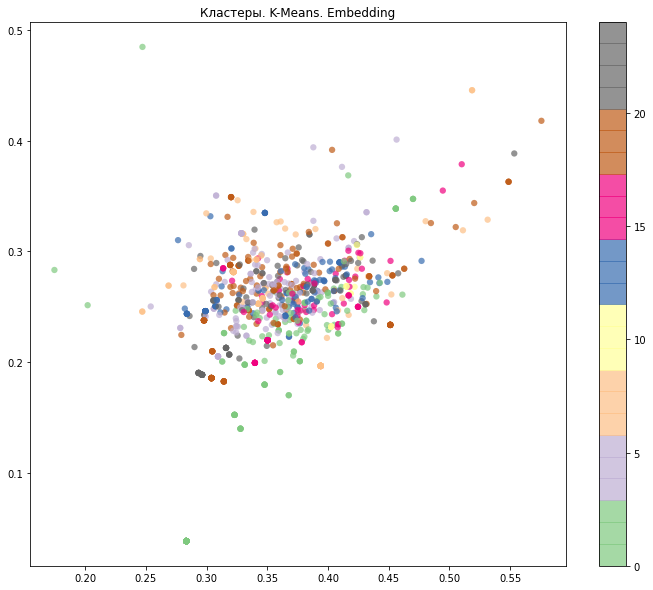

In [27]:
n_clusters = 25
kmeans = KMeans(n_clusters, n_init=500, random_state=17)
e_kmeans = kmeans.fit_transform(X[0])
labels = kmeans.labels_
 

plt.figure(figsize=(12, 10))
plt.scatter(e_kmeans[:, 0], e_kmeans[:, 1], c=labels, edgecolor='none', alpha=0.7, s=40, cmap=plt.cm.get_cmap('Accent', 25))  #nipy_spectral
plt.colorbar()
#centers = kmeans.cluster_centers_
#plt.scatter(centers[:, 0], centers[:, 1], c = 'red', s = 50, alpha = 1)
plt.title('Кластеры. K-Means. Embedding')
plt.show()

In [28]:
# Размер каждого кластера
cluster_size = [sum(labels == i) for i in range(0, n_clusters)]
for i, s in enumerate(cluster_size):
    print(f'Кластер: {i} Размер= {s}')

Кластер: 0 Размер= 3
Кластер: 1 Размер= 199
Кластер: 2 Размер= 12
Кластер: 3 Размер= 21
Кластер: 4 Размер= 8
Кластер: 5 Размер= 102
Кластер: 6 Размер= 47
Кластер: 7 Размер= 49
Кластер: 8 Размер= 13
Кластер: 9 Размер= 12
Кластер: 10 Размер= 4
Кластер: 11 Размер= 14
Кластер: 12 Размер= 33
Кластер: 13 Размер= 65
Кластер: 14 Размер= 20
Кластер: 15 Размер= 42
Кластер: 16 Размер= 5
Кластер: 17 Размер= 33
Кластер: 18 Размер= 34
Кластер: 19 Размер= 142
Кластер: 20 Размер= 15
Кластер: 21 Размер= 74
Кластер: 22 Размер= 8
Кластер: 23 Размер= 29
Кластер: 24 Размер= 16


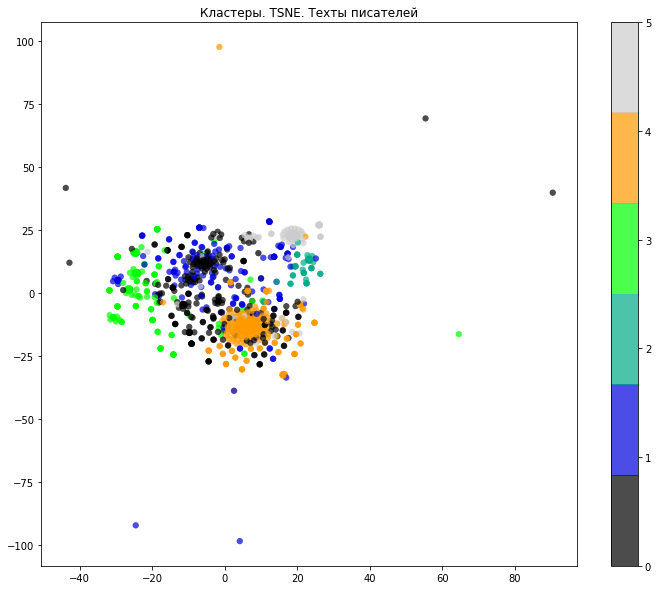

In [103]:
# Вывод 6 кластеров текстов писателей TSNE
tsne = TSNE(n_components=2, random_state=17)
X_tsne = tsne.fit_transform(X[0])

plt.figure(figsize=(12, 10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, edgecolor='none', alpha=0.7, s=40, cmap=plt.cm.get_cmap('nipy_spectral', 6))   #Accent
plt.colorbar()
plt.title('Кластеры. TSNE. Техты писателей')
plt.show()

[(2, 0.7012029443296185), (3, 0.7351612873936774), (4, 0.5256181928077597), (5, 0.9178209765190624)]


Text(0, 0.5, '')

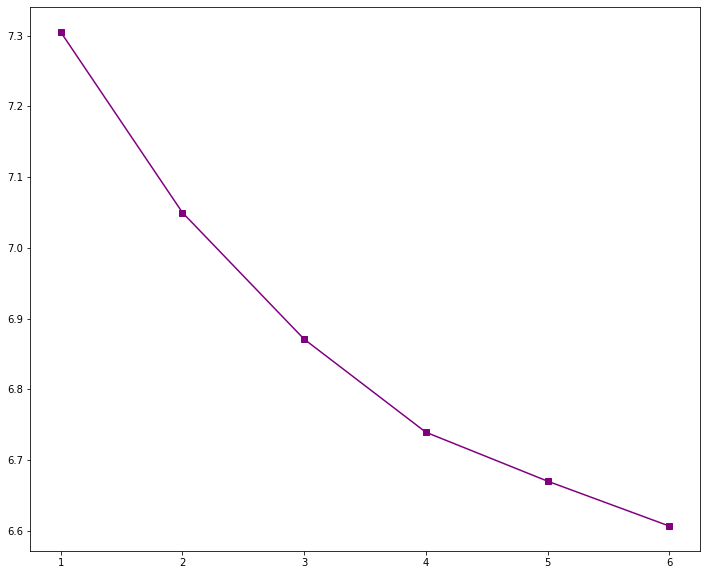

In [30]:
# График 6 колен
N = [i + 1 for i in range(6)]
inertia = []
for k in N:
    kmeans = KMeans(n_clusters=k, random_state=1, n_jobs=4).fit(X[0])
    inertia.append(np.sqrt(kmeans.inertia_))

d_list = [(i + 1, abs((inertia[i] - inertia[i + 1]) / (inertia[i - 1] - inertia[i])))  for i in range(1, len(inertia) - 1)]
print(d_list)

plt.figure(figsize=(12, 10))
plt.plot(N, inertia, marker='s', color='purple')
plt.xlabel('')
plt.ylabel('')

Иерархическая кластеризация

In [70]:
cluster = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')  # Создаем объект AgglomerativeClustering
agglomerative = cluster.fit_predict(X[100])

In [72]:
labels = cluster.labels_ # Получаем список меток
print(labels[:50])

[3 4 0 5 1 1 3 1 3 3 0 5 3 0 3 5 3 3 3 5 1 1 5 3 2 1 3 1 0 3 5 1 1 3 1 2 3
 1 0 5 0 5 3 2 1 1 3 3 5 1]


In [52]:
n_cluster = 5                             # Указываем номер кластера
print(X[1000][labels == n_cluster,:])        # Кластер
print('Размер кластера=', len(X[1000][labels == n_cluster,:]))   # Размер кластера

[[ 0.01114766 -0.0538922  -0.04173541 ... -0.02095833  0.0125608
   0.00282244]
 [ 0.00659065 -0.04197361 -0.01213786 ...  0.02866473 -0.0128761
   0.00626927]
 [-0.0503256  -0.02447314 -0.04766107 ...  0.02441327  0.0076359
   0.01223096]
 ...
 [-0.0384998  -0.06903838 -0.02303412 ... -0.03978076  0.029252
   0.01154904]
 [-0.02365137 -0.01673467  0.02830858 ...  0.023092   -0.03332767
   0.00326118]
 [ 0.01000554 -0.00202938  0.01695795 ... -0.01179294  0.01736186
   0.00449589]]
Размер кластера= 19


In [73]:
def plot_clustering(X_red, labels, title=None):
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)

    plt.figure(figsize=(12, 10))
    for i in range(X_red.shape[0]):
        plt.text(X_red[i, 0], X_red[i, 1], str(labels[i]), 
                 color=plt.cm.nipy_spectral(labels[i] / 6.),
                 fontdict={'weight': 'bold', 'size': 9})

    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

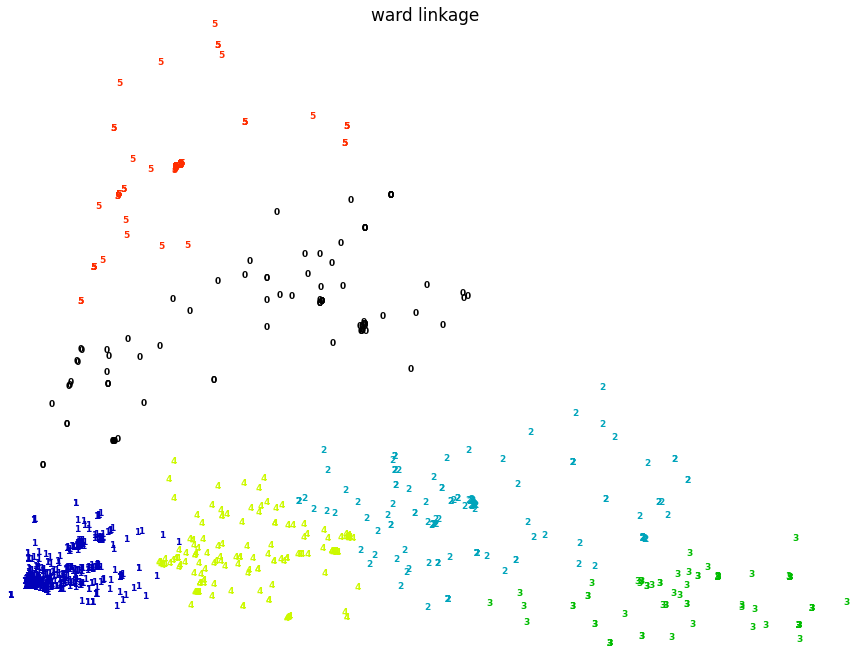

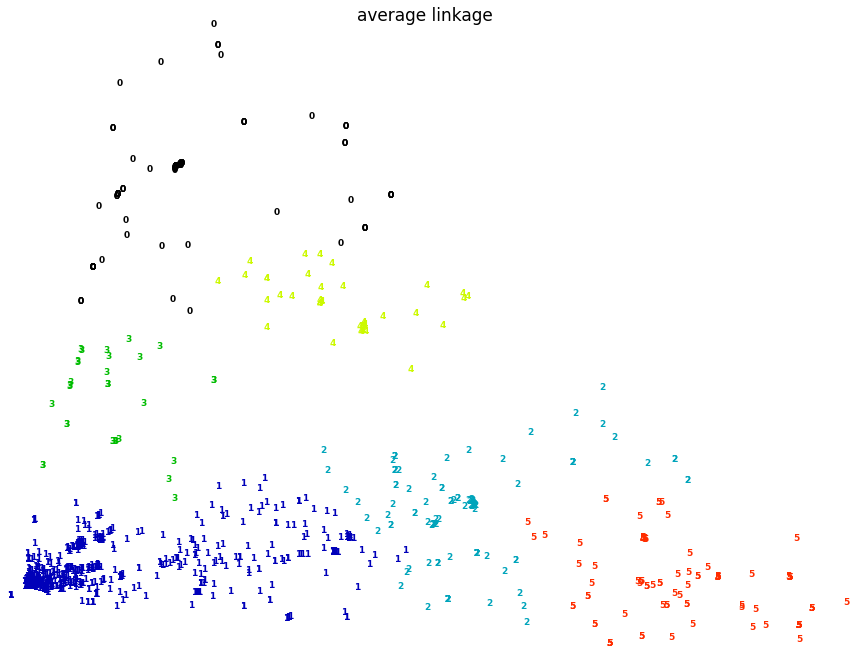

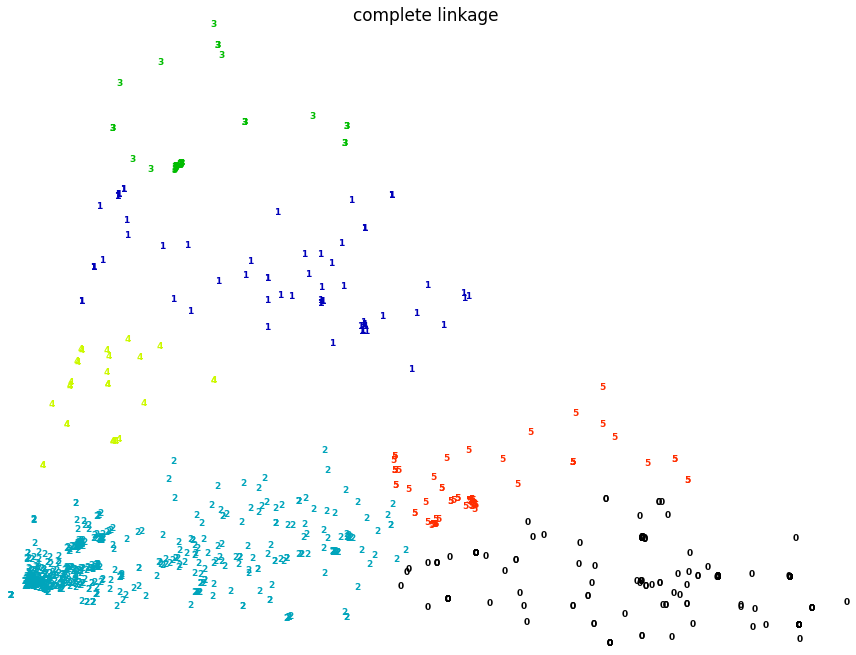

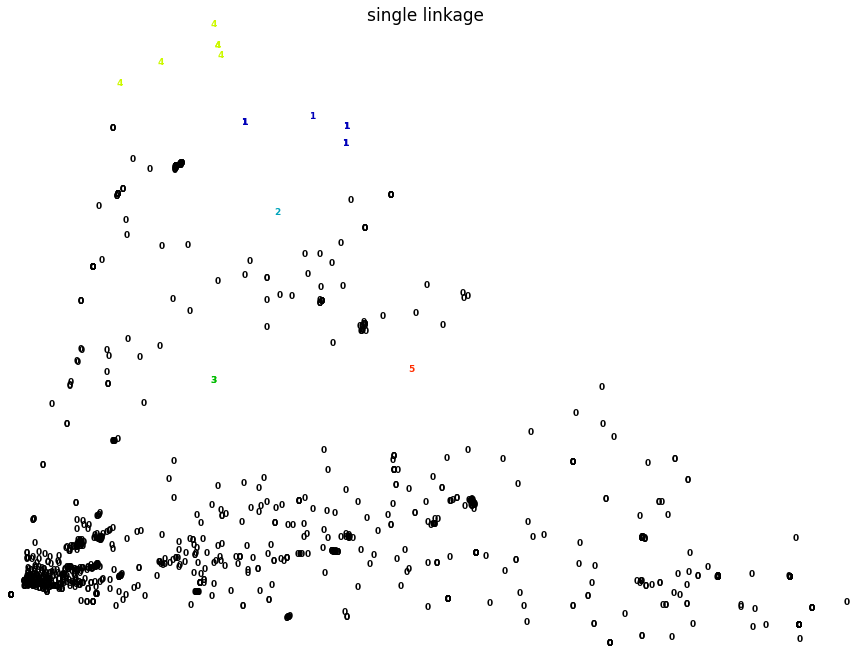

In [74]:
X_red = manifold.SpectralEmbedding(n_components=2).fit_transform(X[0])

for linkage in ('ward', 'average', 'complete', 'single'):
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=6)
    clustering.fit(X_red)
    
    plot_clustering(X_red, clustering.labels_, "%s linkage" % linkage)


plt.show()

Кластеризация текстов писаелей EMBEDDING слоем.

Кластеризация - K-Means

При кластеризации 6 кластерами - кластеры просматриваются четко.

При кластеризации 50 - кластерами высокая плотность и отдельные кластеры тяжело рассмотреть.

К-Means. При кластеризации 25 кластерами - отдельные кластеры хорошо просматриваются. 

6 и 25 кластеров - оказались более оптимальными в данных условиях.

TSNE - кластеры хорошо выделяются по цветам.

Самой наглядной и информативной оказалась Иерархическая кластеризация.


НЕ ПОЛУЧИЛОСЬ ВЫВЕСТИ СОДЕРЖАНИЕ КАЖДОГО КЛАСТЕРА!?